## LSTM using Closing Price
### Recursive Approach (5.1 from report)

Anastasios Koutsogiannopoulos, 03321

Fani Banou, 03322

Ioannis Sakellariou, 03144

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data Loading and Preprocessing

In [ ]:
def mount_drive():
    """
    Mount Google Drive if running on Google Colab.
    """
    try:
        from google.colab import drive
        drive.mount('/content/drive/')
    except ImportError:
        print("Not running on Google Colab; skipping drive mount.")


In [ ]:
def load_and_preprocess():
    """
    Loads the dataset, converts UNIX timestamps to datetime, sorts the data,
    selects the 'close' column, resamples it hourly, and drops missing values.
    Returns a DataFrame with the 'close' values.
    """
    file_path = "/content/drive/MyDrive/bitcoin-dataset.csv"  # Replace with your file path
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['unix'], unit='s')  # Convert UNIX to datetime
    data.set_index('date', inplace=True)
    data = data.sort_index(ascending=True)  # Sort in ascending order

    # Select only numeric columns and then choose the 'close' column
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    data_hourly = numeric_data.resample('1h').mean()
    data_hourly = data_hourly[['close']].dropna()
    return data_hourly

In [ ]:
def scale_data(df):
    """
    Scales the DataFrame with column 'close' using MinMaxScaler.
    Returns the scaled data as a DataFrame preserving the original index and column names
    and the scaler object.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(df)
    data_scaled_df = pd.DataFrame(data_scaled, columns=df.columns, index=df.index)
    return data_scaled_df, scaler


### Data Splitting and Window Creation Functions

In [ ]:
def split_train_test(df):
    """
    Splits the DataFrame into training and testing sets based on fixed date ranges.
    """
    train_end_date = '2022-02-18 23:59:59'  # End of train set
    test_start_date = '2022-02-19 00:00:00'  # Start of test set
    test_end_date = '2022-02-28 23:59:59'      # End of test set
    train_data = df[:train_end_date]
    test_data = df[test_start_date:test_end_date]
    return train_data, test_data, test_start_date, test_end_date


In [ ]:
def create_dataset(data, time_step):
    """
    Creates sliding windows sequences and corresponding targets.

    For each window of length 'time_step', the target is the value of 'close'
    immediately following that window.
    """
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step, 0])  # Target is the 'close' value
    return np.array(X), np.array(y)

### Recursive Forecast Function

In [ ]:
def recursive_forecast(model, last_window, steps):
    """
    Performs recursive forecasting using the trained model.

    Starting with the last available window from the training set, the function
    makes a prediction, appends the prediction to the input sequence shifting it,
    and repeats for the specified number of steps.
    """
    forecast = []
    input_seq = last_window.copy()

    for _ in range(steps):
        # Reshape the input sequence for prediction
        input_seq_reshaped = input_seq.reshape(1, input_seq.shape[0], input_seq.shape[1])
        # Make prediction
        pred = model.predict(input_seq_reshaped, verbose=0)[0, 0]
        forecast.append(pred)
        # Update the input sequence: remove the first value and append the new prediction
        input_seq = np.append(input_seq[1:], [[pred]], axis=0)
    return np.array(forecast)


### Model Building and Training Functions

In [ ]:
def build_model(time_step, num_features):
    """
    Builds and returns a Sequential LSTM model.

    The model consists of three LSTM layers with dropout and two Dense layers.
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(time_step, num_features)),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for predicting 'close'
    ])
    return model

In [ ]:
def train_model(model, X_train, y_train):
    """
    Compiles and trains the model using Adam optimizer and MSE loss.
    Uses early stopping to prevent overfitting.

    Returns the training history.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
    history = model.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=0.2,
                        verbose=1, callbacks=[early_stopping], shuffle=False)
    return history

### Plotting Functions

In [ ]:
def plot_loss_curve(history, title="Loss vs Validation Loss"):
    """
    Plots the training and validation loss curves.
    """
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def plot_forecast(y_true, y_pred, title="Bitcoin Price Prediction (Test Set)"):
    """
    Plots the true vs. predicted Bitcoin prices.
    """
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='True Prices', color='blue')
    plt.plot(y_pred, label='Predicted Prices', color='orange')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Bitcoin Price')
    plt.legend()
    plt.show()


### Predict and Evaluate Function

In [ ]:
def predict_and_evaluate_model(model, X_train, y_test, scaler, history):
    """
    Uses the last training window to perform recursive forecasting, inverse-transforms
    the predictions and test targets, computes evaluation metrics, prints them,
    and plots the forecast and loss curves.
    """
    # Use the last training window for recursive forecasting
    last_window = X_train[-1]
    forecast_steps = len(y_test)
    predictions = recursive_forecast(model, last_window, steps=forecast_steps)

    # Inverse transform predictions and true test values
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    # Plot forecast and loss curves
    plot_forecast(y_test_rescaled, predictions_rescaled, title="Forecast vs True Prices (Single Experiment)")
    plot_loss_curve(history, title="Loss vs Validation Loss (Single Experiment)")

    return mae, rmse, predictions_rescaled, y_test_rescaled


### Multiple Experiments Function

In [ ]:
def run_multiple_experiments(num_runs, train_data, test_data, scaler, time_step=100):
    """
    Runs the complete experiment multiple times num_runs using preprocessed data
    (train_data and test_data) to avoid reprocessing.
    Averages the evaluation metrics MAE, MSE, RMSE and predictions across runs,
    and plots the average forecast and loss curves.
    """
    mae_list = []
    mse_list = []
    rmse_list = []
    predictions_list = []
    histories = []
    train_times = []         # To store execution times for model training
    predict_times = []      # To store execution times for predict

    y_test_rescaled = None  # Will be updated from the last run

    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")
        # Create sliding windows from training set
        X_train, y_train = create_dataset(train_data, time_step)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

        # For the test targets, prepend the last training target to the test series
        last_y_train = y_train[-1]
        y_test = test_data.iloc[:, 0].values
        y_test = np.insert(y_test, 0, last_y_train)

        num_features = X_train.shape[2]
        model = build_model(time_step, num_features)
        start_time = time.time()
        history = train_model(model, X_train, y_train)
        train_time = time.time() - start_time
        train_times.append(train_time)

        # Perform recursive forecasting
        start_time = time.time()
        predictions = recursive_forecast(model, X_train[-1], steps=len(y_test))
        predict_time = time.time() - start_time
        predict_times.append(predict_time)

        # Inverse transform predictions and true test values
        predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
        y_test_res = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Compute evaluation metrics
        mae = mean_absolute_error(y_test_res, predictions_rescaled)
        mse = mean_squared_error(y_test_res, predictions_rescaled)
        rmse = np.sqrt(mse)

        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        predictions_list.append(predictions_rescaled)
        histories.append(history)
        y_test_rescaled = y_test_res  # Test set remains the same across runs

        print(f"Run {run+1} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

    # Compute average metrics over all runs
    avg_mae = np.mean(mae_list)
    avg_mse = np.mean(mse_list)
    avg_rmse = np.mean(rmse_list)
    print(f"\nAverage MAE over {num_runs} runs: {avg_mae:.4f}")
    print(f"Average MSE over {num_runs} runs: {avg_mse:.4f}")
    print(f"Average RMSE over {num_runs} runs: {avg_rmse:.4f}")

    # Compute and print average execution times
    avg_train_time = np.mean(train_times)
    avg_predict_time = np.mean(predict_times)
    print(f"\nAverage Execution Times over {num_runs} Runs:")
    print(f"Model Training Time: {avg_train_time:.4f} seconds")
    print(f"Predicting Time: {avg_predict_time:.4f} seconds")

    # Average predictions across runs
    avg_predictions = np.mean(np.array(predictions_list), axis=0)
    plot_forecast(y_test_rescaled, avg_predictions, title="Average Forecast vs True Prices (Multiple Runs)")

    # Average loss curves over runs using the minimum number of epochs across runs
    min_epochs = min(len(h.history['loss']) for h in histories)
    avg_loss = np.mean([h.history['loss'][:min_epochs] for h in histories], axis=0)
    avg_val_loss = np.mean([h.history['val_loss'][:min_epochs] for h in histories], axis=0)

    plt.figure(figsize=(10,5))
    epochs_range = range(1, min_epochs+1)
    plt.plot(epochs_range, avg_loss, label="Average Training Loss")
    plt.plot(epochs_range, avg_val_loss, label="Average Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Average Loss Curves over {num_runs} Runs")
    plt.legend()
    plt.show()

### Main Function

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Running Multiple Experiments (10 runs)...
Run 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0200 - mean_absolute_error: 0.1166 - val_loss: 0.0446 - val_mean_absolute_error: 0.2087
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0302 - mean_absolute_error: 0.1518 - val_loss: 0.0168 - val_mean_absolute_error: 0.1229
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0134 - mean_absolute_error: 0.0870 - val_loss: 6.8355e-04 - val_mean_absolute_error: 0.0190
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0051 - mean_absolute_error: 0.0521 - val_loss: 6.5289e-04 - val_mean_absolute_error: 0.0188
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0029 - mean_absolute_error: 0.0404 - val_loss: 7.3862e-04 - val_mean_absolute_error: 0.0219
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - mean_absolute_error: 0.0354 - val_loss: 6.1517e-04 - val_mean_absolute_error: 0.0185
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - mean_absolute_error: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0177 - mean_absolute_error: 0.1037 - val_loss: 0.1301 - val_mean_absolute_error: 0.3578
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0634 - mean_absolute_error: 0.2108 - val_loss: 0.0070 - val_mean_absolute_error: 0.0755
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0136 - mean_absolute_error: 0.0839 - val_loss: 0.0013 - val_mean_absolute_error: 0.0297
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0039 - mean_absolute_error: 0.0474 - val_loss: 5.9983e-04 - val_mean_absolute_error: 0.0171
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - mean_absolute_error: 0.0418 - val_loss: 5.1305e-04 - val_mean_absolute_error: 0.0158
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027 - mean_absolute_error: 0.0388 - val_loss: 5.7834e-04 - val_mean_absolute_error: 0.0179
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024 - mean_absolute_error: 0.0362 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0916 - mean_absolute_error: 0.2592 - val_loss: 0.0080 - val_mean_absolute_error: 0.0682
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0180 - mean_absolute_error: 0.1104 - val_loss: 0.0715 - val_mean_absolute_error: 0.2642
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0280 - mean_absolute_error: 0.1363 - val_loss: 0.0065 - val_mean_absolute_error: 0.0731
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0079 - mean_absolute_error: 0.0647 - val_loss: 0.0073 - val_mean_absolute_error: 0.0799
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0072 - mean_absolute_error: 0.0636 - val_loss: 0.0035 - val_mean_absolute_error: 0.0520
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0050 - mean_absolute_error: 0.0517 - val_loss: 0.0012 - val_mean_absolute_error: 0.0263
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0037 - mean_absolute_error: 0.0444 - val_loss: 5.8309e-0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0252 - mean_absolute_error: 0.1328 - val_loss: 0.1230 - val_mean_absolute_error: 0.3483
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0479 - mean_absolute_error: 0.1833 - val_loss: 0.0042 - val_mean_absolute_error: 0.0546
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0130 - mean_absolute_error: 0.0871 - val_loss: 0.0028 - val_mean_absolute_error: 0.0470
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0049 - mean_absolute_error: 0.0526 - val_loss: 9.3441e-04 - val_mean_absolute_error: 0.0231
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0035 - mean_absolute_error: 0.0430 - val_loss: 6.4885e-04 - val_mean_absolute_error: 0.0177
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0032 - mean_absolute_error: 0.0410 - val_loss: 5.1268e-04 - val_mean_absolute_error: 0.0154
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028 - mean_absolute_error: 0.0389 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0356 - mean_absolute_error: 0.1568 - val_loss: 0.1042 - val_mean_absolute_error: 0.3193
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0534 - mean_absolute_error: 0.1937 - val_loss: 0.0038 - val_mean_absolute_error: 0.0513
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0099 - mean_absolute_error: 0.0758 - val_loss: 0.0032 - val_mean_absolute_error: 0.0520
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0049 - mean_absolute_error: 0.0529 - val_loss: 5.3035e-04 - val_mean_absolute_error: 0.0158
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033 - mean_absolute_error: 0.0418 - val_loss: 5.4659e-04 - val_mean_absolute_error: 0.0163
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028 - mean_absolute_error: 0.0390 - val_loss: 5.6847e-04 - val_mean_absolute_error: 0.0178
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034 - mean_absolute_error: 0.0423 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0221 - mean_absolute_error: 0.1245 - val_loss: 0.1200 - val_mean_absolute_error: 0.3450
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0420 - mean_absolute_error: 0.1729 - val_loss: 0.0069 - val_mean_absolute_error: 0.0733
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0107 - mean_absolute_error: 0.0807 - val_loss: 0.0016 - val_mean_absolute_error: 0.0337
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0050 - mean_absolute_error: 0.0523 - val_loss: 8.4538e-04 - val_mean_absolute_error: 0.0225
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - mean_absolute_error: 0.0432 - val_loss: 5.7418e-04 - val_mean_absolute_error: 0.0167
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032 - mean_absolute_error: 0.0411 - val_loss: 5.3020e-04 - val_mean_absolute_error: 0.0167
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0032 - mean_absolute_error: 0.0412 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0264 - mean_absolute_error: 0.1353 - val_loss: 0.1561 - val_mean_absolute_error: 0.3924
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0589 - mean_absolute_error: 0.2040 - val_loss: 0.0050 - val_mean_absolute_error: 0.0622
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0138 - mean_absolute_error: 0.0874 - val_loss: 0.0055 - val_mean_absolute_error: 0.0699
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0057 - mean_absolute_error: 0.0594 - val_loss: 8.6217e-04 - val_mean_absolute_error: 0.0216
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0033 - mean_absolute_error: 0.0423 - val_loss: 6.3518e-04 - val_mean_absolute_error: 0.0175
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0030 - mean_absolute_error: 0.0404 - val_loss: 5.2754e-04 - val_mean_absolute_error: 0.0155
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - mean_absolute_error: 0.0377 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0170 - mean_absolute_error: 0.1021 - val_loss: 0.0257 - val_mean_absolute_error: 0.1531
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0396 - mean_absolute_error: 0.1757 - val_loss: 0.0194 - val_mean_absolute_error: 0.1365
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0252 - mean_absolute_error: 0.1263 - val_loss: 0.0067 - val_mean_absolute_error: 0.0782
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0066 - mean_absolute_error: 0.0633 - val_loss: 6.1264e-04 - val_mean_absolute_error: 0.0177
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036 - mean_absolute_error: 0.0443 - val_loss: 4.5229e-04 - val_mean_absolute_error: 0.0146
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0027 - mean_absolute_error: 0.0388 - val_loss: 5.0638e-04 - val_mean_absolute_error: 0.0169
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023 - mean_absolute_error: 0.0353 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0239 - mean_absolute_error: 0.1280 - val_loss: 0.1092 - val_mean_absolute_error: 0.3278
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0461 - mean_absolute_error: 0.1828 - val_loss: 0.0063 - val_mean_absolute_error: 0.0698
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0148 - mean_absolute_error: 0.0904 - val_loss: 0.0017 - val_mean_absolute_error: 0.0349
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048 - mean_absolute_error: 0.0532 - val_loss: 5.3468e-04 - val_mean_absolute_error: 0.0163
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - mean_absolute_error: 0.0406 - val_loss: 5.3247e-04 - val_mean_absolute_error: 0.0165
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027 - mean_absolute_error: 0.0383 - val_loss: 5.4369e-04 - val_mean_absolute_error: 0.0170
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024 - mean_absolute_error: 0.0361 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0226 - mean_absolute_error: 0.1219 - val_loss: 0.0785 - val_mean_absolute_error: 0.2789
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0322 - mean_absolute_error: 0.1523 - val_loss: 0.0019 - val_mean_absolute_error: 0.0338
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0067 - mean_absolute_error: 0.0649 - val_loss: 7.5682e-04 - val_mean_absolute_error: 0.0203
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0045 - mean_absolute_error: 0.0488 - val_loss: 6.0167e-04 - val_mean_absolute_error: 0.0185
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0031 - mean_absolute_error: 0.0407 - val_loss: 6.8147e-04 - val_mean_absolute_error: 0.0208
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - mean_absolute_error: 0.0363 - val_loss: 6.5666e-04 - val_mean_absolute_error: 0.0194
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032 - mean_absolute_error: 0.0421 - val

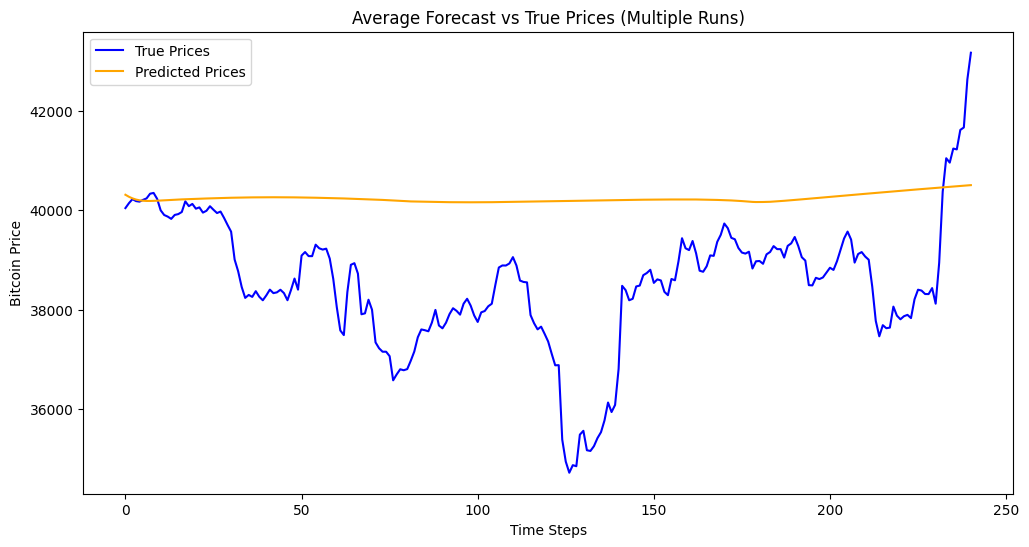

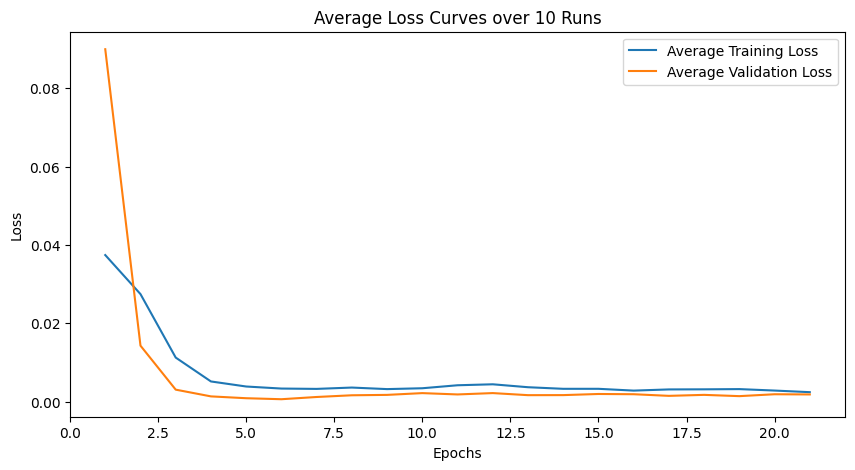

In [ ]:
def main():

    # Mount Google Drive
    mount_drive()

    # Define the file path for the dataset
    file_path = "/content/drive/MyDrive/bitcoin-dataset.csv"

    # Load and preprocess data
    data_hourly = load_and_preprocess()
    data_scaled_df, scaler = scale_data(data_hourly)

    # Split data into train and test sets
    train_data, test_data, test_start_date, test_end_date = split_train_test(data_scaled_df)

    # Create sliding windows from training set
    time_step = 60
    # X_train, y_train = create_dataset(train_data, time_step)
    # X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

    # # For the test targets, we prepend the last training target to the test series
    # last_y_train = y_train[-1]
    # y_test = test_data.iloc[:, 0].values
    # y_test = np.insert(y_test, 0, last_y_train)

    # # Build and train the model
    # num_features = X_train.shape[2]
    # model = build_model(time_step, num_features)
    # history = train_model(model, X_train, y_train)

    # # Predict and evaluate using our dedicated function
    # predict_and_evaluate_model(model, X_train, y_test, scaler, history)

    # --- Multiple Experiments ---
    print("\nRunning Multiple Experiments (10 runs)...")
    run_multiple_experiments(num_runs=10, train_data=train_data, test_data=test_data, scaler=scaler, time_step=time_step)

if __name__ == "__main__":
    main()